# Compare All Mines to EPA data

In [ ]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
import fiona
try:
    import seaborn as sns
except ModuleNotFoundError:
    !conda install seaborn --yes
    import seaborn as sns
import utils
import seaborn as sns
fiona.drvsupport.supported_drivers['kml'] = 'rw'
fiona.drvsupport.supported_drivers['KML'] = 'rw'

from utils import open_all_FF_tables
import mine_emis
import config
# https://www.epa.gov/enviro/greenhouse-gas-subpart-ff-model 

In [3]:
EMISSIONS_PER_DAY = "../data/kelly_plumes_20250211/radial_MAD_alpha/emissions_per_day.csv" #'../data/kelly_plumes_20241018/simple_emissions_per_day.csv'
VENT_FILE = '../data/labeled_vents.kml'
LUT = '../data/facility_lookup.csv'

FF_TABLES = config.FF_TABLES

In [4]:
emissions_per_mine_per_quarter = mine_emis.carbonmapper(emissions_per_day_file=EMISSIONS_PER_DAY, lookup_table_file=LUT, vent_file=VENT_FILE)
epa_summary = mine_emis.ghgrp()

# sum_degas['kg_hr'] = sum_degas.weekly_volumetric_flow_rate * utils.MT_QRT_TO_KG_HR #qrt or week
epa_summary.loc[:,'qtr_fac_total_qrtly_netch4emis'] = epa_summary.qtr_fac_total_qrtly_netch4emis * utils.MT_QRT_TO_KG_HR
epa_summary.loc[:,'qtr_meth_liber_vent_calc'] = epa_summary.qtr_meth_liber_vent_calc * utils.MT_QRT_TO_KG_HR
epa_summary.loc[:,'qtr_meth_liber_degas_calc'] = epa_summary.qtr_meth_liber_degas_calc * utils.MT_QRT_TO_KG_HR
epa_summary.loc[:,'qtr_meth_dest_trns_offste_calc'] = epa_summary.qtr_meth_dest_trns_offste_calc * utils.MT_QRT_TO_KG_HR
epa_summary.loc[:,'net_well_emis'] = epa_summary.net_well_emis * utils.MT_QRT_TO_KG_HR

comparison = pd.merge(emissions_per_mine_per_quarter, 
                           epa_summary, 
                           right_on=['facility_id', 'facility_name', 'reporting_year', 'quarter'], 
                           left_on=['facility_id', 'facility_name', 'year', 'quarter'],
                           how='left').reset_index()
# TODO: double check the facility name on merge isn't messing stuff up (I think it is)

Fixing number of shafts in: OAK GROVE MINE
Fixing number of shafts in: OAK GROVE MINE
Fixing number of shafts in: BAILEY MINE-CRABAPPLE PORTAL
Fixing number of shafts in: ENLOW FORK MINE
Fixing number of shafts in: HARVEY MINE
Fixing number of shafts in: HARRISON COUNTY MINE
Fixing number of shafts in: MARION COUNTY MINE
Fixing number of shafts in: MARION COUNTY MINE
Fixing number of shafts in: MARSHALL COUNTY MINE
Fixing number of shafts in: MARSHALL COUNTY MINE
Fixing number of shafts in: MONONGALIA COUNTY MINE
Fixing number of shafts in: MONONGALIA COUNTY MINE
Fixing number of shafts in: LEER SOUTH MINING COMPLEX


In [5]:
print("mines reporting to EPA, 2022")
epa_summary[epa_summary.reporting_year==2022].facility_id.nunique()

mines reporting to EPA, 2022


62

In [6]:
print("mines gob well emis to EPA, 2022")
epa_summary[(epa_summary.reporting_year==2022)&(epa_summary.net_well_emis>0)].facility_id.nunique()

mines gob well emis to EPA, 2022


13

In [7]:
print("number of mines CM surveys total")
emissions_per_mine_per_quarter.facility_name.nunique() -1 # remove unknown mine

number of mines CM surveys total


24

In [8]:
vdf = utils.open_all_FF_tables()['FF_VENTILATION_QTRLY']

Fixing number of shafts in: OAK GROVE MINE
Fixing number of shafts in: OAK GROVE MINE
Fixing number of shafts in: BAILEY MINE-CRABAPPLE PORTAL
Fixing number of shafts in: ENLOW FORK MINE
Fixing number of shafts in: HARVEY MINE
Fixing number of shafts in: HARRISON COUNTY MINE
Fixing number of shafts in: MARION COUNTY MINE
Fixing number of shafts in: MARION COUNTY MINE
Fixing number of shafts in: MARSHALL COUNTY MINE
Fixing number of shafts in: MARSHALL COUNTY MINE
Fixing number of shafts in: MONONGALIA COUNTY MINE
Fixing number of shafts in: MONONGALIA COUNTY MINE
Fixing number of shafts in: LEER SOUTH MINING COMPLEX


In [ ]:
def fix_mine_name(s):
    """
    Fix capitalization of mine names to comply with USGS formatting requirements. 
    """
    return s.title().replace('Llc',"LLC"
                   ).replace('Mine', 'mine'
                   ).replace('Bailey mine-Crabapple Portal', 'Bailey Mine-Crabapple portal'
                   ).replace('Mccoy', 'McCoy'
                   ).replace('Warrior Met Coal mine #4', 'Warrior Met Coal Mine #4'
                   ).replace('Mining Complex', 'mining complex'
                   ).replace('Icg', 'ICG')

def plot_mine_level_comparison(df, x_col, y_col, bin_col, bin_list=None, title='', letter_level="", xlim=(0.,18000.), ylim=(0.,18000.), ax=None):
    if ax is None:
        fig, ax = plt.subplots(dpi=300)
        
    nonzero_mines = df[y_col]>0
    sufficient_vents = (df.vent_vent_id/df.num_of_shafts) > 0.75
    ax.set_prop_cycle('color',plt.cm.tab20(np.linspace(0,1,20)))
    for mine_name in bin_list if (bin_list is not None) else df[bin_col].unique():
        is_mine = df[bin_col]==mine_name
        mask = nonzero_mines & is_mine & sufficient_vents
        if mask.sum() < 1:
            continue
        # plot scatter
        ax.errorbar(x=df[mask][x_col], 
                    y=df[mask][y_col], 
                    xerr=df[mask][x_col]*0.3,
                    yerr=df[mask].vent_emission_uncertainty_auto, 
                    fmt='o', label=fix_mine_name(mine_name))
    # plot 1:1
    ax.plot(xlim, 
            xlim, 
            'k-', label='1:1')
    
# Compute regression + bootstrapped slope std dev
    slope, intercept, r = utils.rma_regression(df[x_col], df[y_col])
    bs_mean_slope, bs_std = utils.bootstrap_rma_slope(df[x_col].values, df[y_col].values)

    # Plot regression line
    ax.plot(xlim, 
            np.array(xlim) * slope + intercept, 
            'k--', label='RMA regression')

    # Inset text box with r and slope ± std
    textstr = '\n'.join((
        rf'RMA slope = {slope:.1f} $\pm$ {bs_std:.2f}',
        rf'$r$ = {r:.2f}'
    ))
    ax.text(x=0.98*xlim[1], y=0.02*ylim[1], s=textstr,
            horizontalalignment='right',
            verticalalignment='bottom',)
            #bbox=dict(edgecolor='k', facecolor='none', boxstyle='round,pad=0.3'))
    
    # Inset text box with title
    ax.text(0.02, 0.98, title,
            transform=ax.transAxes,
            weight="bold",
            ha='left', va='top',)
            #bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))


    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    # Match number of tick labels on both axes
    n_ticks = 5  # or whatever number of ticks you prefer
    xticks = np.linspace(xlim[0], xlim[1], n_ticks)
    yticks = np.linspace(ylim[0], ylim[1], n_ticks)
    ax.tick_params(labelsize=12)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_title(letter_level, loc='left')
    ax.set_aspect('equal')

    if ax is None:
        ax.set_xlabel('EPA Ventilation (kg/hr)')
        ax.set_ylabel('Observed Emissions (kg/hr)')
        ax.legend(fontsize=6.5, loc='lower right', ncol=1, boxstyle='round,pad=0.3')


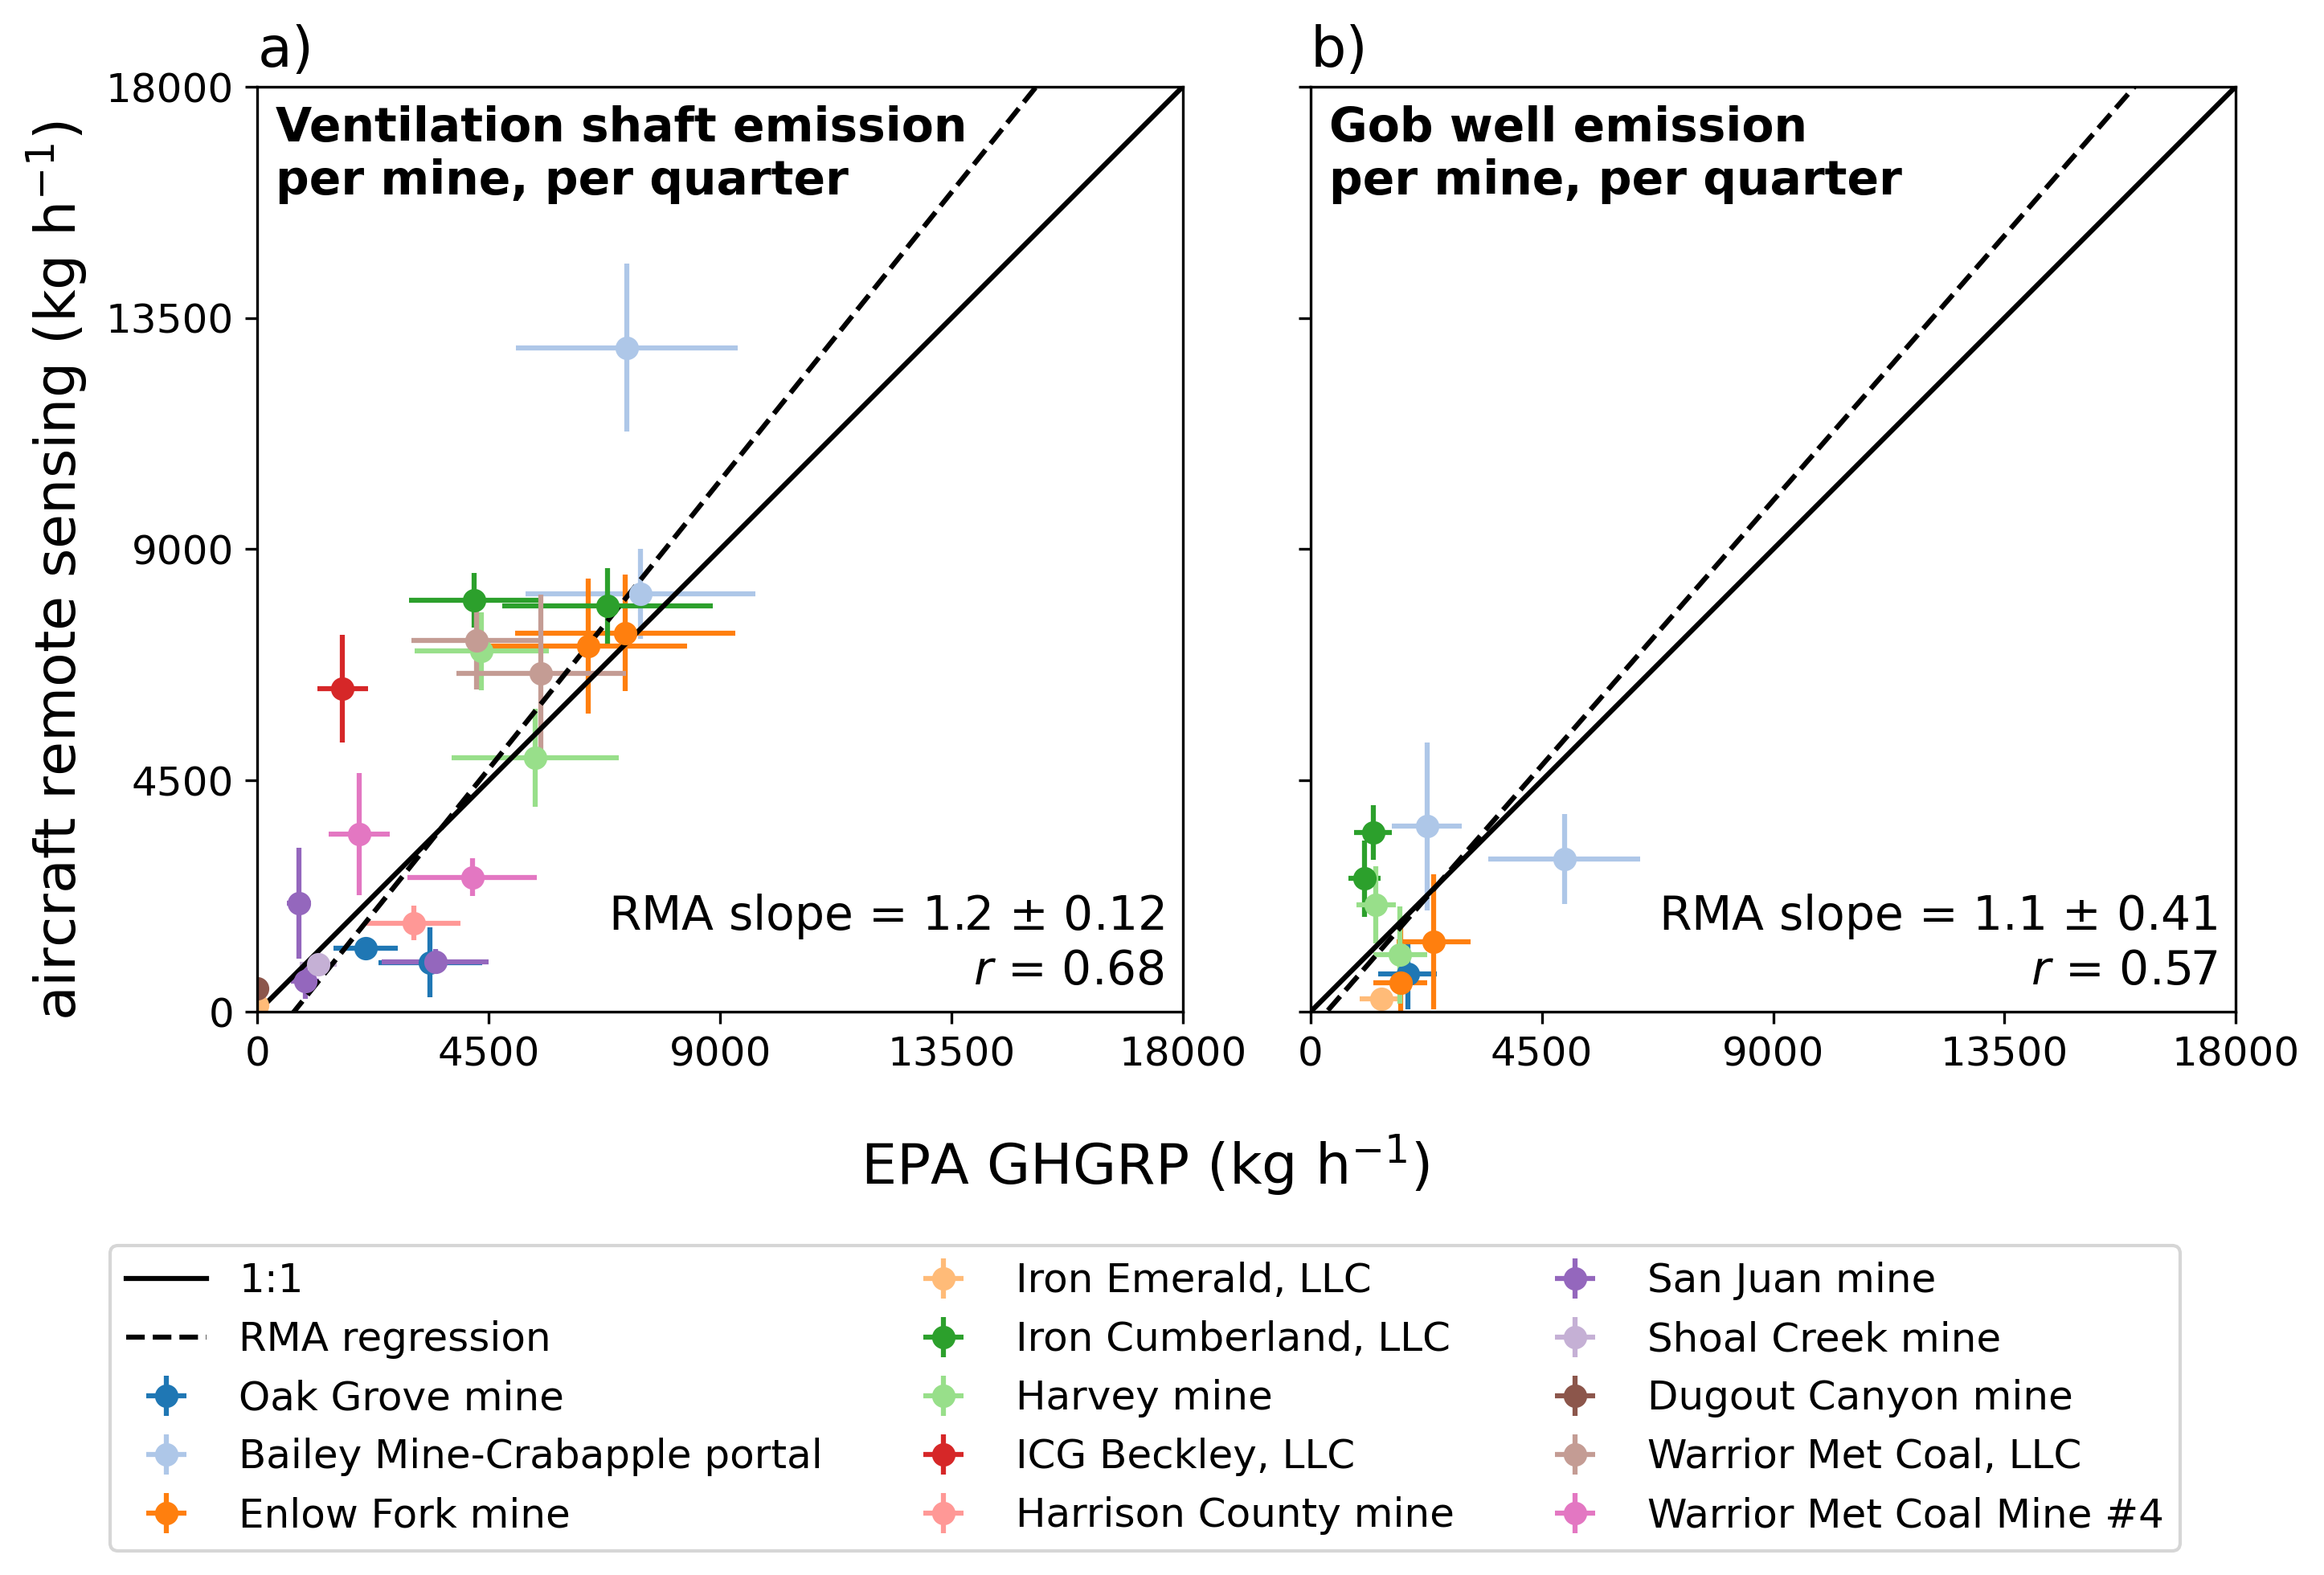

In [44]:
fig, axs = plt.subplots(1,2,figsize=(10,5), dpi=300, sharey=True)
plt.rcParams.update({'font.size': 14})

# put mines with degas wells first so colors are consistent
nonzero_wells = comparison['well_emission_auto']>0
sufficient_vents = (comparison.vent_vent_id/comparison.num_of_shafts) > 0.75
first_mines = comparison[nonzero_wells & sufficient_vents].facility_name.unique().tolist()
rest_of_mines = comparison.facility_name[~comparison.facility_name.isin(first_mines)].unique().tolist()
mine_list = first_mines + rest_of_mines

plot_mine_level_comparison(df=comparison, 
                           x_col='qtr_meth_liber_vent_calc', 
                           y_col='vent_emission_auto', 
                           bin_col='facility_name', 
                           bin_list=mine_list, # custom order of mines
                           title='Ventilation shaft emission\nper mine, per quarter',
                           letter_level="a)",
                           ax=axs[0])

plot_mine_level_comparison(df=comparison, 
                           x_col='net_well_emis', 
                           y_col='well_emission_auto', 
                           bin_col='facility_name', 
                           bin_list=mine_list, # custom order of mines
                           title='Gob well emission\nper mine, per quarter',
                           letter_level="b)",
                           ax=axs[1])

fig.legend(*axs[0].get_legend_handles_labels(), loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.3), fontsize=12)
fig.supxlabel('EPA GHGRP ($\mathrm{kg\ h^{-1}}$)')
fig.supylabel('aircraft remote sensing ($\mathrm{kg\ h^{-1}}$)', x=0.035, y=0.53)
plt.tight_layout()
plt.savefig('./figures/figure_2.png')

In [18]:
print("percent of gob well emissions at mines emitting from gob wells in EPA GHGRP")
mines_w_wells = epa_summary[(epa_summary['net_well_emis']>0)&(epa_summary['reporting_year']==2022)]
mines_w_wells['net_well_emis'].sum() / (mines_w_wells['net_well_emis'].sum() + mines_w_wells['qtr_meth_liber_vent_calc'].sum())

percent of gob well emissions at mines emitting from gob wells in EPA GHGRP


0.25514633918214363

In [19]:
mines = ["IRON CUMBERLAND, LLC", "ENLOW FORK MINE", "BAILEY MINE-CRABAPPLE PORTAL","OAK GROVE MINE", "HARVEY MINE", "IRON EMERALD, LLC"]
mines_w_wells = comparison[comparison.facility_name.isin(mines)]
mines_w_wells['well_emission_auto'].sum() / mines_w_wells['total_emission_auto'].sum()

0.23030238180388782